<a href="https://colab.research.google.com/github/OMRNASSER/Python/blob/main/Task7__omar_abd_el_nasser_ahmed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

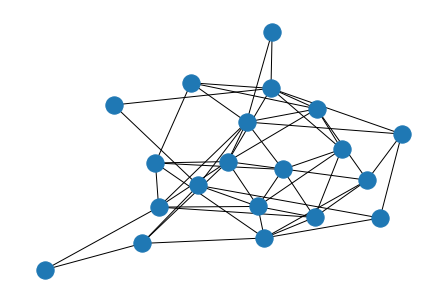

In [1]:
%matplotlib inline
import networkx as nx

G = nx.gnm_random_graph(20, 50)
nx.draw(G)

In [2]:
def initial_state(G):
    state = {}
    for node in G.nodes:
        state[node] = 'asleep'
    return state

In [4]:
initial_state(G)

{0: 'asleep',
 1: 'asleep',
 2: 'asleep',
 3: 'asleep',
 4: 'asleep',
 5: 'asleep',
 6: 'asleep',
 7: 'asleep',
 8: 'asleep',
 9: 'asleep',
 10: 'asleep',
 11: 'asleep',
 12: 'asleep',
 13: 'asleep',
 14: 'asleep',
 15: 'asleep',
 16: 'asleep',
 17: 'asleep',
 18: 'asleep',
 19: 'asleep'}

In [6]:
import random

P_AWAKEN = 0.2
def state_transition(G, current_state):
    next_state = {}
    for node in G.nodes:
        if current_state[node] == 'asleep':
            if random.random() < P_AWAKEN:
                next_state[node] = 'awake'
    return next_state
test_state = initial_state(G)
state_transition(G, test_state)

{3: 'awake', 14: 'awake', 17: 'awake'}

In [7]:
from collections import Counter
from operator import itemgetter

import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx


class StopCondition(StopIteration):
    pass

class Simulation:
    '''Simulate state transitions on a network'''

    def __init__(self, G, initial_state, state_transition,
            stop_condition=None, name=''):
        '''
        Create a Simulation instance.
        Args:
            G: a networkx.Graph instance.
            initial_state: function with signature `initial_state(G)`, that
                accepts a single argument, the Graph, and returns a dictionary
                of all node states. The keys in this dict should be node names
                and the values the corresponding initial node state.
            state_transition: function with signature
                `state_transition(G, current_state)` that accepts two
                arguments, the Graph and a dictionary of current node states,
                and returns a dictionary of updated node states. The keys in
                this dict should be node names and the values the corresponding
                updated node state.
            stop_condition (optional): function with signature
                `stop_condition(G, current_state)` that accepts two arguments,
                the Graph and a dictionary of current node states, and returns
                True if the simulation should be stopped at its current state.
        Keyword Args:
            name (optional): a string used in titles of plots and drawings.
        Raises:
            ValueError: if not all graph nodes have an initial state.
        '''
        self.G = G.copy()
        self._initial_state = initial_state
        self._state_transition = state_transition
        self._stop_condition = stop_condition
        # It's okay to specify stop_condition=False
        if stop_condition and not callable(stop_condition):
            raise TypeError("'stop_condition' should be a function")
        self.name = name or 'Simulation'

        self._states = []
        self._value_index = {}
        self._cmap = plt.cm.get_cmap('tab10')

        self._initialize()

        self._pos = nx.layout.spring_layout(G)

    def _append_state(self, state):
        self._states.append(state)
        # Update self._value_index
        for value in set(state.values()):
            if value not in self._value_index:
                self._value_index[value] = len(self._value_index)

    def _initialize(self):
        if self._initial_state:
            if callable(self._initial_state):
                state = self._initial_state(self.G)
            else:
                state = self._initial_state
            nx.set_node_attributes(self.G, state, 'state')

        if any(self.G.nodes[n].get('state') is None for n in self.G.nodes):
            raise ValueError('All nodes must have an initial state')

        self._append_state(state)

    def _step(self):
        # We're choosing to use the node attributes as the source of truth.
        # This allows the user to manually perturb the network in between steps.
        state = nx.get_node_attributes(self.G, 'state')
        if self._stop_condition and self._stop_condition(self.G, state):
            raise StopCondition
        state = nx.get_node_attributes(self.G, 'state')
        new_state = self._state_transition(self.G, state)
        state.update(new_state)
        nx.set_node_attributes(self.G, state, 'state')
        self._append_state(state)

    def _categorical_color(self, value):
        index = self._value_index[value]
        node_color = self._cmap(index)
        return node_color

    @property
    def steps(self):
        ''' Returns the number of steps the sumulation has run '''
        return len(self._states) - 1

    def state(self, step=-1):
        '''
        Get a state of the simulation; by default returns the current state.
        Args:
            step: the step of the simulation to return. Default is -1, the
            current state.
        Returns:
            Dictionary of node states.
        Raises:
            IndexError: if `step` argument is greater than the number of steps.
        '''
        try:
            return self._states[step]
        except IndexError:
            raise IndexError('Simulation step %i out of range' % step)

    def draw(self, step=-1, labels=None, **kwargs):
        '''
        Use networkx.draw to draw a simulation state with nodes colored by
        their state value. By default, draws the current state.
        Args:
            step: the step of the simulation to draw. Default is -1, the
            current state.
            kwargs: keyword arguments are passed to networkx.draw()
        Raises:
            IndexError: if `step` argument is greater than the number of steps.
        '''
        state = self.state(step)
        node_colors = [self._categorical_color(state[n]) for n in self.G.nodes]
        nx.draw(self.G, pos=self._pos, node_color=node_colors, **kwargs)

        if labels is None:
            labels = sorted(set(state.values()), key=self._value_index.get)
        patches = [mpl.patches.Patch(color=self._categorical_color(l), label=l)
                   for l in labels]
        plt.legend(handles=patches)

        if step == -1:
            step = self.steps
        if step == 0:
            title = 'initial state'
        else:
            title = 'step %i' % (step)
        if self.name:
            title = '{}: {}'.format(self.name, title)
        plt.title(title)

    def plot(self, min_step=None, max_step=None, labels=None, **kwargs):
        '''
        Use pyplot to plot the relative number of nodes with each state at each
        simulation step. By default, plots all simulation steps.
        Args:
            min_step: the first step of the simulation to draw. Default is
                None, which plots starting from the initial state.
            max_step: the last step, not inclusive, of the simulation to draw.
                Default is None, which plots up to the current step.
            labels: ordered sequence of state values to plot. Default is all
                observed state values, approximately ordered by appearance.
            kwargs: keyword arguments are passed along to plt.plot()
        Returns:
            Axes object for the current plot
        '''
        x_range = range(min_step or 0, max_step or len(self._states))
        counts = [Counter(s.values()) for s in self._states[min_step:max_step]]
        if labels is None:
            labels = {k for count in counts for k in count}
            labels = sorted(labels, key=self._value_index.get)

        for label in labels:
            series = [count.get(label, 0) / sum(count.values()) for count in counts]
            plt.plot(x_range, series, label=label, **kwargs)

        title = 'node state proportions'
        if self.name:
            title = '{}: {}'.format(self.name, title)
        plt.title(title)
        plt.xlabel('Simulation step')
        plt.ylabel('Proportion of nodes')
        plt.legend()
        plt.xlim(x_range.start)

        return plt.gca()

    def run(self, steps=1):
        '''
        Run the simulation one or more steps, as specified by the `steps`
        argument. Default is to run a single step.
        Args:
            steps: number of steps to advance the simulation.
        '''
        for _ in range(steps):
            try:
                self._step()
            except StopCondition as e:
                print(
                    "Stop condition met at step %i." % self.steps
                    )
                break

1

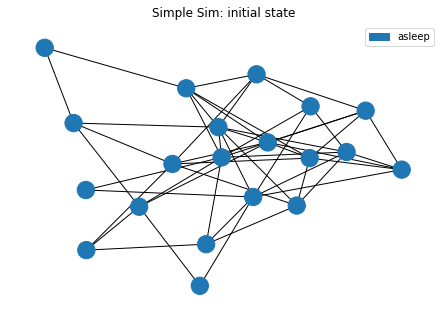

In [15]:


sim = Simulation(G, initial_state, state_transition, name='Simple Sim')
sim.state()
sim.draw()
sim.run()
sim.steps


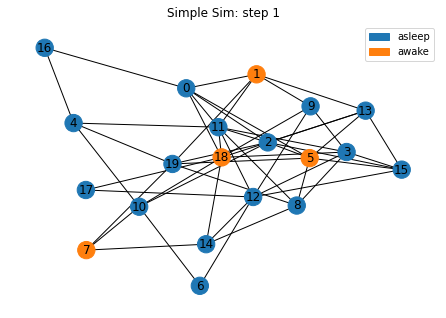

In [16]:
sim.draw(with_labels=True)

In [18]:
sim.state()

{0: 'asleep',
 1: 'awake',
 2: 'asleep',
 3: 'asleep',
 4: 'asleep',
 5: 'awake',
 6: 'asleep',
 7: 'awake',
 8: 'asleep',
 9: 'asleep',
 10: 'asleep',
 11: 'asleep',
 12: 'asleep',
 13: 'asleep',
 14: 'asleep',
 15: 'asleep',
 16: 'asleep',
 17: 'asleep',
 18: 'awake',
 19: 'asleep'}

In [24]:
sim.run(10) 
sim.steps

71

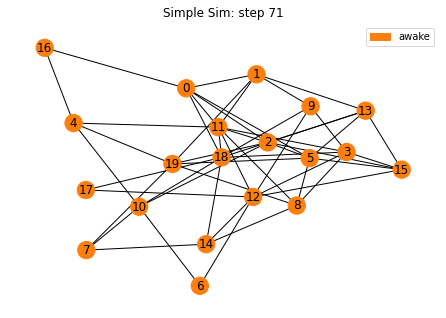

In [25]:
sim.draw(with_labels=True)


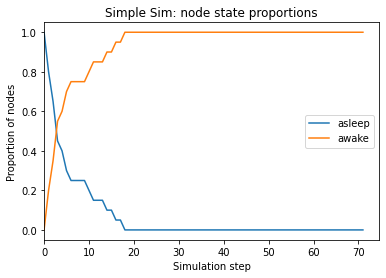

In [26]:
sim.plot()

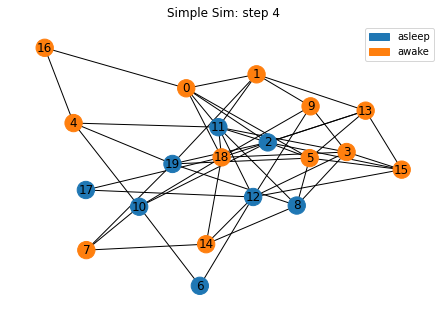

In [28]:
sim.draw(4, with_labels=True)


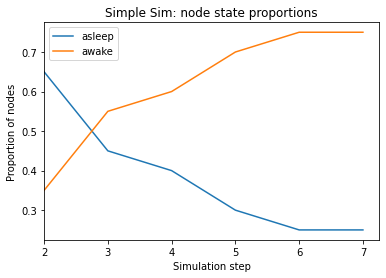

In [29]:
sim.plot(min_step=2, max_step=8)


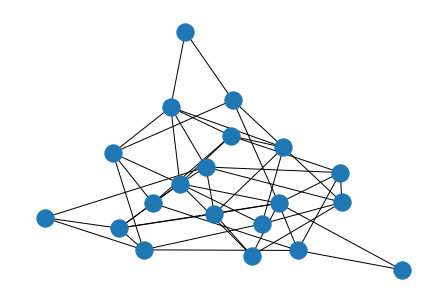

In [30]:
%matplotlib inline
import networkx as nx

G = nx.gnm_random_graph(20, 50)
nx.draw(G)

In [32]:
import random
import string

def initial_state(G):
    state = {}
    for node in G.nodes:
        state[node] = random.choice('ABCD')
    return state
initial_state(G)


{0: 'B',
 1: 'C',
 2: 'C',
 3: 'A',
 4: 'B',
 5: 'C',
 6: 'D',
 7: 'B',
 8: 'B',
 9: 'C',
 10: 'B',
 11: 'A',
 12: 'A',
 13: 'D',
 14: 'B',
 15: 'D',
 16: 'D',
 17: 'C',
 18: 'B',
 19: 'D'}

In [33]:
def state_transition(G, current_state):
    next_state = {}
    for node in G.nodes:
        # Caveat: what if the node has no neighbors?
        if G.degree(node) > 0:
            neighbor = random.choice(list(G.neighbors(node)))
            next_state[node] = current_state[neighbor]
    return next_state

In [36]:
test_state = initial_state(G)
state_transition(G, test_state)

{0: 'D',
 1: 'D',
 2: 'A',
 3: 'A',
 4: 'C',
 5: 'A',
 6: 'C',
 7: 'D',
 8: 'C',
 9: 'A',
 10: 'A',
 11: 'D',
 12: 'D',
 13: 'D',
 14: 'A',
 15: 'B',
 16: 'B',
 17: 'A',
 18: 'C',
 19: 'B'}

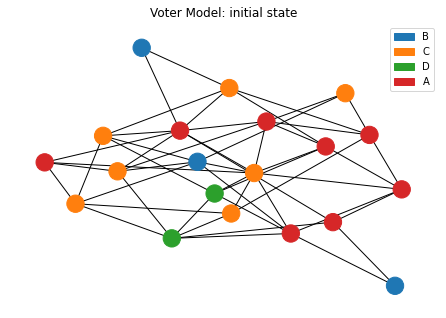

In [38]:
import matplotlib.pyplot as plt

sim = Simulation(G, initial_state, state_transition, name='Voter Model')
sim.draw()


In [39]:
sim.run(40)

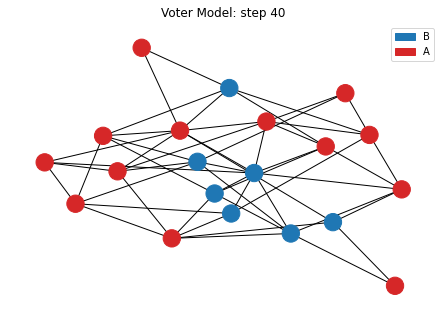

In [40]:
sim.draw()

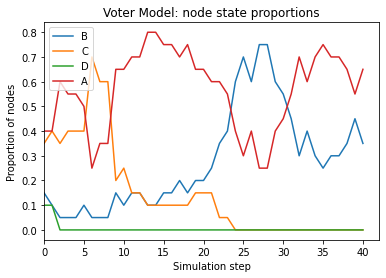

In [41]:
sim.plot()


In [42]:
import random

def state_transition(G, current_state):
    next_state = {}
    for node in G.nodes:
        if G.degree(node) > 0:
            neighbor = random.choice(list(G.neighbors(node)))
            next_state[node] = current_state[neighbor]
    return next_state

In [43]:
def state_transition_async(G, current_state):
    for node in G.nodes:
        if G.degree(node) > 0:
            neighbor = random.choice(list(G.neighbors(node)))
            current_state[node] = current_state[neighbor]
    return current_state

In [44]:
def state_transition_async(G, current_state):
    # Randomizing the update order prevents bias
    nodes_to_update = list(G.nodes)
    random.shuffle(nodes_to_update)
    for node in nodes_to_update:
        if G.degree(node) > 0:
            neighbor = random.choice(list(G.neighbors(node)))
            current_state[node] = current_state[neighbor]
    return current_state

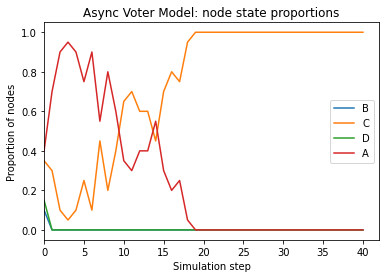

In [45]:
sim = Simulation(G, initial_state, state_transition_async, name='Async Voter Model')
sim.run(40)
sim.plot()

In [46]:
def stop_condition(G, current_state):
    unique_state_values = set(current_state.values())
    is_stopped = len(unique_state_values) <= 1
    return is_stopped

In [47]:
sim = Simulation(G, initial_state, state_transition, stop_condition, name='Voter model')
sim.run(100)

Stop condition met at step 26.


In [48]:
sim.steps

26

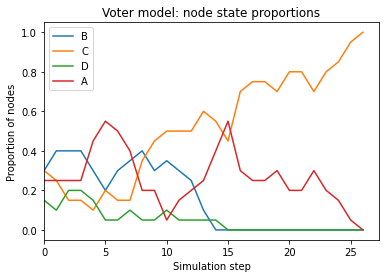

In [49]:
sim.plot()


In [50]:
def state_transition_async_rewiring(G, current_state):
    # Randomizing the update order prevents bias
    nodes_to_update = list(G.nodes)
    random.shuffle(nodes_to_update)
    for node in nodes_to_update:
        if G.degree(node) > 0:
            # This is the same as before
            neighbor = random.choice(list(G.neighbors(node)))
            current_state[node] = current_state[neighbor]
            # This is the new part
            neighbor = random.choice(list(G.neighbors(node)))
            if current_state[node] != current_state[neighbor]:
                G.remove_edge(node, neighbor)
            
    return current_state

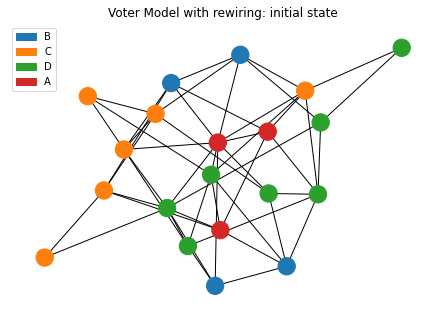

In [51]:
sim = Simulation(G, initial_state, state_transition_async_rewiring, stop_condition,
                 name='Voter Model with rewiring')
sim.draw()

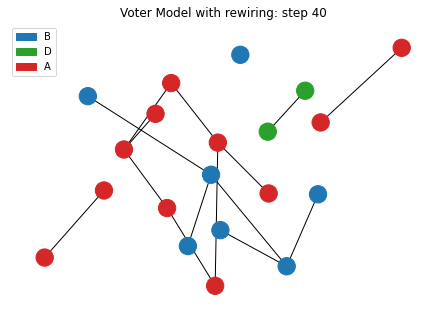

In [52]:
sim.run(40)
sim.draw()

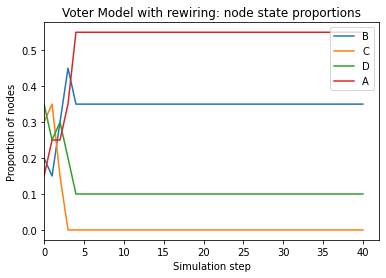

In [53]:
sim.plot()

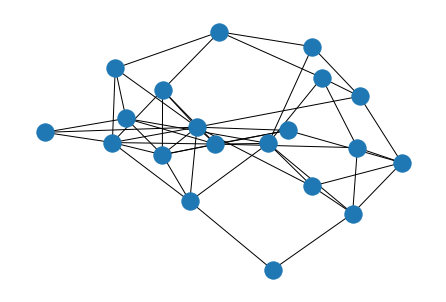

In [54]:
%matplotlib inline
import networkx as nx

G = nx.gnm_random_graph(20, 50)
nx.draw(G)

In [55]:
import random

def initial_state(G):
    state = {}
    for node in G.nodes:
        state[node] = 'S'
    
    patient_zero = random.choice(list(G.nodes))
    state[patient_zero] = 'I'
    return state

In [57]:
initial_state(G)


{0: 'S',
 1: 'S',
 2: 'I',
 3: 'S',
 4: 'S',
 5: 'S',
 6: 'S',
 7: 'S',
 8: 'S',
 9: 'S',
 10: 'S',
 11: 'S',
 12: 'S',
 13: 'S',
 14: 'S',
 15: 'S',
 16: 'S',
 17: 'S',
 18: 'S',
 19: 'S'}

In [58]:
MU = 0.1
BETA = 0.1

def state_transition(G, current_state):
    next_state = {}
    for node in G.nodes:
        if current_state[node] == 'I':
            if random.random() < MU:
                next_state[node] = 'S'
        else: # current_state[node] == 'S'
            for neighbor in G.neighbors(node):
                if current_state[neighbor] == 'I':
                    if random.random() < BETA:
                        next_state[node] = 'I'

    return next_state

In [60]:
test_state = initial_state(G)
state_transition(G, test_state)

{}

In [61]:
sim = Simulation(G, initial_state, state_transition, name='SIS model')

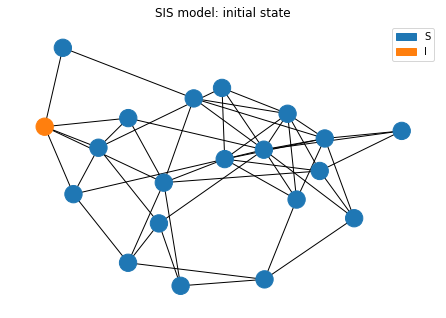

In [62]:
sim.draw()


In [63]:
sim.run(25)


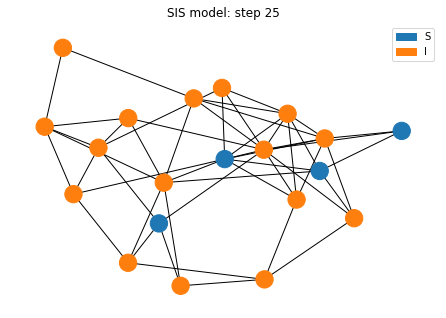

In [64]:
sim.draw()


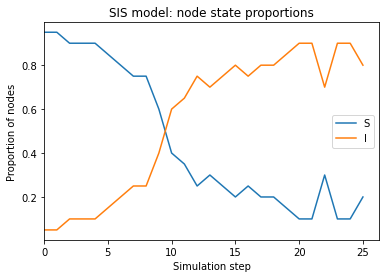

In [65]:
sim.plot()
